In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
blacknguyen119_dataset_fall_path = kagglehub.dataset_download('blacknguyen119/dataset-fall')

print('Data source import complete.')


Using Colab cache for faster access to the 'dataset-fall' dataset.
Data source import complete.


In [ ]:
blacknguyen119_dataset_fall_path

'/kaggle/input/dataset-fall'

In [ ]:
# import os
# import cv2
# import numpy as np
# from pathlib import Path
# from tqdm import tqdm
# import pickle

# def extract_and_save_frames(dataset_root, output_root, num_frames=16):
#     """
#     Tách tất cả video thành frames và lưu vào disk
#     Structure: output_root/split/class/video_id/frame_00.npy
#     """
#     dataset_root = Path(dataset_root)
#     output_root = Path(output_root)

#     for split in ['train', 'val', 'test']:
#         for cls in ['Fall', 'No_Fall']:
#             video_dir = dataset_root / split / cls / 'Raw_Video'
#             if not video_dir.exists():
#                 continue

#             videos = [v for v in video_dir.glob('*.mp4') if 'resized' not in v.name]

#             for video_path in tqdm(videos, desc=f"{split}/{cls}"):
#                 video_id = video_path.stem
#                 output_dir = output_root / split / cls / video_id
#                 output_dir.mkdir(parents=True, exist_ok=True)

#                 # Extract frames
#                 cap = cv2.VideoCapture(str(video_path))
#                 total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

#                 if total_frames >= num_frames:
#                     indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
#                 else:
#                     indices = np.arange(0, total_frames)
#                     indices = np.concatenate([indices, np.full(num_frames - total_frames, indices[-1])])

#                 frames = []
#                 for idx in indices:
#                     cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
#                     ret, frame = cap.read()
#                     if ret:
#                         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#                         frame = cv2.resize(frame, (288, 288), interpolation=cv2.INTER_AREA)
#                         frames.append(frame)

#                 cap.release()

#                 # Save as numpy array (nhanh hơn ảnh riêng lẻ)
#                 np.save(output_dir / 'frames.npy', np.array(frames, dtype=np.uint8))

# # Chạy 1 lần duy nhất
# extract_and_save_frames(
#     dataset_root='/kaggle/input/dataset-fall/split_dataset',
#     output_root='frames_extracted',
#     num_frames=32
# )

In [ ]:
def extract_frame(video_input, num_frames):
    #Trích xuất num_frames từ video
    try:
      cap = cv2.VideoCapture(video_input)
      total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
      frames = []
      if total_frames >= num_frames:
          index_frames = np.linspace(0, total_frames - 1, num_frames, dtype=int)
      else:
          index_frame = np.arange(0, total_frames)
          #Lặp lại frame cuối
          index_frame_lack = np.full(num_frames - total_frames, index_frame[-1])
          index_frames = np.concatenate((index_frame, index_frame_lack))
      for index_frame in index_frames:
          cap.set(cv2.CAP_PROP_POS_FRAMES, index_frame)
          ret, frame = cap.read()
          if ret:
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              # frame_resize = cv2.resize(frame, (img_size, img_size))
              frames.append(frame)
      return np.array(frames)
    finally:
      cap.release()

In [ ]:
import os
os.cpu_count()


12

In [ ]:
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
train_path = '/kaggle/input/dataset-fall/split_dataset/train'
classes = ['Fall', 'No_Fall']
for cls in classes:
    train_cls_path = os.path.join(train_path, cls, 'Raw_Video')
    number_video_cls_in_train = len(os.listdir(train_cls_path))
    print(f"{cls}: have {number_video_cls_in_train} video")

Fall: have 2512 video
No_Fall: have 3078 video


In [ ]:
count_video_each_cls = []
for cls in classes:
    count_video_no_resized = 0
    train_cls_path = os.path.join(train_path, cls, 'Raw_Video')
    for video_name in os.listdir(train_cls_path):
        if re.search('resized', video_name) is None:
            count_video_no_resized += 1
    count_video_each_cls.append(count_video_no_resized)
    print(f'{cls} have {count_video_no_resized} satisfied')

Fall have 1654 satisfied
No_Fall have 2026 satisfied


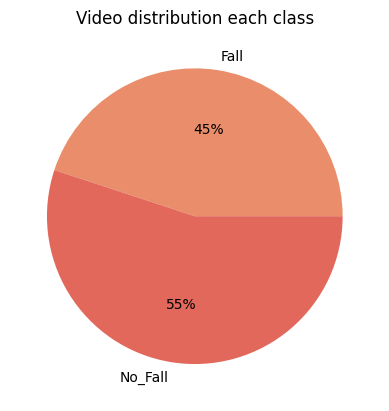

In [ ]:
labels = ['Fall', 'No_Fall']
colors = sns.color_palette('flare')

plt.pie(count_video_each_cls, labels = labels, colors = colors, autopct = '%0.f%%')
plt.title('Video distribution each class')
plt.show()

In [ ]:
!pip -q install albumentations

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from pathlib import Path

In [ ]:
IMG_HEIGHT = 288
IMG_WIDTH = 288
NUM_FRAMES = 32
BATCH_SIZE = 8
NUM_WORKERS = os.cpu_count() - 2

In [ ]:
train_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    # A.RandomCrop(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit = 15, p = 0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2),
    A.GaussNoise(p=0.2),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    A.ToTensorV2()
])
val_test_transform = A.Compose([
    A.Resize(height=IMG_HEIGHT, width=IMG_WIDTH),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    A.ToTensorV2()
])

In [ ]:
class FallDetectionDatasetPreExtracted(Dataset):
    def __init__(self, frames_root, split, transform):
        self.frames_root = Path(frames_root) / split
        self.transform = transform

        self.frame_paths = []
        self.labels = []

        for cls_idx, cls in enumerate(['Fall', 'No_Fall']):
            cls_dir = self.frames_root / cls
            if cls_dir.exists():
                for video_dir in cls_dir.iterdir():
                    frame_file = video_dir / 'frames.npy'
                    if frame_file.exists():
                        self.frame_paths.append(frame_file)
                        self.labels.append(1 if cls == 'Fall' else 0)

    def __len__(self):
        return len(self.frame_paths)

    def __getitem__(self, idx):
        # Load frames (CỰC NHANH vì đã tách sẵn)
        frames = np.load(self.frame_paths[idx])
        label = self.labels[idx]

        # Apply transform
        augmented_frames = self.transform(images=frames)['images']

        return augmented_frames, label

In [ ]:
train_dataset = FallDetectionDatasetPreExtracted(
    frames_root='/content/frames_extracted',
    split='train',
    transform=train_transform
)

val_dataset = FallDetectionDatasetPreExtracted(
    frames_root='/content/frames_extracted',
    split='val',
    transform=val_test_transform
)


test_dataset = FallDetectionDatasetPreExtracted(
    frames_root='/content/frames_extracted',
    split='test',
    transform=val_test_transform
)

In [ ]:
len(train_dataset), len(val_dataset)

(3680, 474)

In [ ]:
# DataLoader với cấu hình tối ưu
train_batch = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,  # Tăng batch size
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)
val_batch = DataLoader(val_dataset,
                       batch_size = BATCH_SIZE,
                       shuffle = True,
                       num_workers = NUM_WORKERS,
                       pin_memory=True,  # Thêm
                       persistent_workers=True  # Thêm
                       )
test_batch = DataLoader(test_dataset,
                       batch_size = BATCH_SIZE,
                       shuffle = True,
                       num_workers = NUM_WORKERS,
                       pin_memory=True,  # Thêm
                       persistent_workers=True  # Thêm
                       )

In [ ]:
# batch = next(iter(train_batch))     # lấy 1 batch
# if isinstance(batch, (list, tuple)):
#     images, targets = batch
# else:
#     images = batch

# print("images:", images.shape)       # ví dụ: torch.Size([B, C, H, W])
# print("targets:", getattr(targets, "shape", None))

In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class EfficientNetLSTM(nn.Module):
    def __init__(self, hidden_size=256, num_layers=2, dropout=0.5):
        super(EfficientNetLSTM, self).__init__()

        weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
        self.efficientnet = efficientnet_v2_s(weights=weights)
        num_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Identity()

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Linear(256*2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256,128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 1) # không Sigmoid
        )

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)
        features = self.efficientnet(x)
        features = features.view(batch_size, num_frames, -1)
        lstm_out, _ = self.lstm(features)

        final_features = lstm_out[:, -1, :]

        output = self.fc(final_features)
        return output.squeeze()  # Remove extra dimension


In [ ]:
# import timm
# from torch import nn
# class FallDetectionModel(nn.Module):
#     def __init__(self, num_frames=30, num_classes=2):
#         super().__init__()
#         self.num_frames = num_frames

#         # 1. CNN Feature Extractor (EfficientNetV2-S)
#         self.cnn_backbone = timm.create_model(
#             'efficientnetv2_rw_s.ra2_in1k',
#             pretrained=True,
#             num_classes=0,  # Remove classification head
#             global_pool=''  # Remove global pooling # có thể đặt là global_pool = 'avg' nếu muốn bỏ dòng dưới
#         )

#         # Global Average Pooling để giảm spatial dimensions
#         self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

#         # Feature dimension từ EfficientNetV2-S
#         self.feature_dim = 1280  # Output channels của stage cuối

#         # 2. LSTM cho temporal modeling
#         self.lstm = nn.LSTM(
#             input_size=self.feature_dim,
#             hidden_size=512,
#             num_layers=2,
#             batch_first=True,
#             bidirectional=True,
#             dropout=0.3
#         )

#         # 3. Classification head
#         self.classifier = nn.Sequential(
#             nn.Linear(1024, 512),  # 1024 = 512*2 (bidirectional)
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         """
#         Input: x shape = (batch_size, num_frames, channels, height, width)
#                e.g., (4, 30, 3, 224, 224)
#         """
#         batch_size, num_frames, C, H, W = x.shape

#         # Reshape để xử lý tất cả frames cùng lúc qua CNN
#         x = x.view(batch_size * num_frames, C, H, W)
#         # Shape: (120, 3, 224, 224) với batch_size=4, num_frames=30

#         # Extract features từ CNN
#         features = self.cnn_backbone(x)
#         # Shape: (120, 1280, 7, 7) - spatial features

#         # Global pooling để loại bỏ spatial dimensions
#         features = self.global_pool(features)
#         # Shape: (120, 1280, 1, 1)

#         features = features.squeeze(-1).squeeze(-1)
#         # Shape: (120, 1280)

#         # Reshape lại theo batch và sequence
#         features = features.view(batch_size, num_frames, self.feature_dim)
#         # Shape: (4, 30, 1280)

#         # LSTM processing
#         lstm_out, (hidden, cell) = self.lstm(features)
#         # lstm_out shape: (4, 30, 1024) - output at mỗi timestep
#         # hidden shape: (4, 2, 512) - final hidden states

#         # Lấy output của timestep cuối cùng
#         final_output = lstm_out[:, -1, :]
#         # Shape: (4, 1024)

#         # Classification
#         output = self.classifier(final_output)
#         # Shape: (4, 2) - logits cho 2 classes

#         return output

In [ ]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for videos, labels in tqdm(dataloader, desc="Training"):
        videos = videos.to(device)
        labels = labels.float().to(device)  # Convert to float for BCE

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Threshold 0.5
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(dataloader, desc="Validation"):
            videos = videos.to(device)
            labels = labels.float().to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return epoch_loss, epoch_acc, precision, recall, f1

In [ ]:
# Training code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetLSTM(hidden_size=256, num_layers=2, dropout=0.5).to(device)

print("Đóng băng các lớp EfficientNet...")
for param in model.efficientnet.parameters():
    param.requires_grad = False
print("Đã đóng băng! Chỉ train LSTM + FC.")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

NUM_EPOCHS = 50
BEST_VAL_LOSS = float('inf')
# Lưu lịch sử training
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

# patience_counter = 0
# EARLY_STOP_PATIENCE = 7
# Training loop
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    # Train
    train_loss, train_acc = train_one_epoch(model, train_batch, criterion, optimizer, device)

    # Validate
    val_loss, val_acc, val_precision, val_recall, val_f1 = validate(model, val_batch, criterion, device)

    # Scheduler step
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_loss < BEST_VAL_LOSS:
        BEST_VAL_LOSS = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ Saved best model (Val Loss: {val_loss:.4f})")


Đóng băng các lớp EfficientNet...
Đã đóng băng! Chỉ train LSTM + FC.
Starting training...

Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.02it/s]


Train Loss: 0.5263 | Train Acc: 0.7101
Val Loss: 0.4024 | Val Acc: 0.8312
Val Precision: 0.7520 | Val Recall: 0.9069 | Val F1: 0.8222
Current LR: 0.001000
✓ Saved best model (Val Loss: 0.4024)

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


Train Loss: 0.4379 | Train Acc: 0.7630
Val Loss: 0.3531 | Val Acc: 0.8544
Val Precision: 0.8358 | Val Recall: 0.8235 | Val F1: 0.8296
Current LR: 0.001000
✓ Saved best model (Val Loss: 0.3531)

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.15it/s]


Train Loss: 0.3842 | Train Acc: 0.8014
Val Loss: 0.2975 | Val Acc: 0.8840
Val Precision: 0.9209 | Val Recall: 0.7990 | Val F1: 0.8556
Current LR: 0.001000
✓ Saved best model (Val Loss: 0.2975)

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.14it/s]


Train Loss: 0.3761 | Train Acc: 0.8065
Val Loss: 0.3072 | Val Acc: 0.8797
Val Precision: 0.9249 | Val Recall: 0.7843 | Val F1: 0.8488
Current LR: 0.001000

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


Train Loss: 0.3570 | Train Acc: 0.8160
Val Loss: 0.2549 | Val Acc: 0.8903
Val Precision: 0.8762 | Val Recall: 0.8676 | Val F1: 0.8719
Current LR: 0.001000
✓ Saved best model (Val Loss: 0.2549)

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.18it/s]


Train Loss: 0.3458 | Train Acc: 0.8212
Val Loss: 0.2790 | Val Acc: 0.8882
Val Precision: 0.8512 | Val Recall: 0.8971 | Val F1: 0.8735
Current LR: 0.001000

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s]


Train Loss: 0.3433 | Train Acc: 0.8351
Val Loss: 0.2674 | Val Acc: 0.8987
Val Precision: 0.8714 | Val Recall: 0.8971 | Val F1: 0.8841
Current LR: 0.001000

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.26it/s]


Train Loss: 0.3032 | Train Acc: 0.8560
Val Loss: 0.3479 | Val Acc: 0.8797
Val Precision: 0.8551 | Val Recall: 0.8676 | Val F1: 0.8613
Current LR: 0.001000

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


Train Loss: 0.3131 | Train Acc: 0.8476
Val Loss: 0.2645 | Val Acc: 0.8840
Val Precision: 0.8634 | Val Recall: 0.8676 | Val F1: 0.8655
Current LR: 0.000500

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.23it/s]


Train Loss: 0.2940 | Train Acc: 0.8533
Val Loss: 0.2707 | Val Acc: 0.8882
Val Precision: 0.8545 | Val Recall: 0.8922 | Val F1: 0.8729
Current LR: 0.000500

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.14it/s]


Train Loss: 0.2532 | Train Acc: 0.8829
Val Loss: 0.2401 | Val Acc: 0.9008
Val Precision: 0.9026 | Val Recall: 0.8627 | Val F1: 0.8822
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.2401)

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.31it/s]


Train Loss: 0.2563 | Train Acc: 0.8853
Val Loss: 0.2043 | Val Acc: 0.9072
Val Precision: 0.8922 | Val Recall: 0.8922 | Val F1: 0.8922
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.2043)

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.19it/s]


Train Loss: 0.2438 | Train Acc: 0.8842
Val Loss: 0.2636 | Val Acc: 0.9135
Val Precision: 0.8826 | Val Recall: 0.9216 | Val F1: 0.9017
Current LR: 0.000500

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.16it/s]


Train Loss: 0.2348 | Train Acc: 0.8812
Val Loss: 0.1948 | Val Acc: 0.9283
Val Precision: 0.9427 | Val Recall: 0.8873 | Val F1: 0.9141
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.1948)

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.13it/s]


Train Loss: 0.2240 | Train Acc: 0.8946
Val Loss: 0.1962 | Val Acc: 0.9198
Val Precision: 0.9560 | Val Recall: 0.8529 | Val F1: 0.9016
Current LR: 0.000500

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.17it/s]


Train Loss: 0.2277 | Train Acc: 0.8927
Val Loss: 0.1906 | Val Acc: 0.9283
Val Precision: 0.9427 | Val Recall: 0.8873 | Val F1: 0.9141
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.1906)

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.23it/s]


Train Loss: 0.1909 | Train Acc: 0.9177
Val Loss: 0.2249 | Val Acc: 0.9198
Val Precision: 0.8952 | Val Recall: 0.9216 | Val F1: 0.9082
Current LR: 0.000500

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.20it/s]


Train Loss: 0.1936 | Train Acc: 0.9177
Val Loss: 0.1958 | Val Acc: 0.9515
Val Precision: 0.9458 | Val Recall: 0.9412 | Val F1: 0.9435
Current LR: 0.000500

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.13it/s]


Train Loss: 0.2130 | Train Acc: 0.8992
Val Loss: 0.2507 | Val Acc: 0.9177
Val Precision: 0.8873 | Val Recall: 0.9265 | Val F1: 0.9065
Current LR: 0.000500

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.34it/s]


Train Loss: 0.1879 | Train Acc: 0.9163
Val Loss: 0.1870 | Val Acc: 0.9451
Val Precision: 0.9363 | Val Recall: 0.9363 | Val F1: 0.9363
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.1870)

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.30it/s]


Train Loss: 0.2095 | Train Acc: 0.9090
Val Loss: 0.1711 | Val Acc: 0.9430
Val Precision: 0.9155 | Val Recall: 0.9559 | Val F1: 0.9353
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.1711)

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.31it/s]


Train Loss: 0.2013 | Train Acc: 0.9082
Val Loss: 0.1794 | Val Acc: 0.9536
Val Precision: 0.9596 | Val Recall: 0.9314 | Val F1: 0.9453
Current LR: 0.000500

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.43it/s]


Train Loss: 0.1959 | Train Acc: 0.9141
Val Loss: 0.1764 | Val Acc: 0.9557
Val Precision: 0.9463 | Val Recall: 0.9510 | Val F1: 0.9487
Current LR: 0.000500

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.40it/s]


Train Loss: 0.1900 | Train Acc: 0.9174
Val Loss: 0.1655 | Val Acc: 0.9557
Val Precision: 0.9420 | Val Recall: 0.9559 | Val F1: 0.9489
Current LR: 0.000500
✓ Saved best model (Val Loss: 0.1655)

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.33it/s]


Train Loss: 0.1685 | Train Acc: 0.9293
Val Loss: 0.1696 | Val Acc: 0.9494
Val Precision: 0.9167 | Val Recall: 0.9706 | Val F1: 0.9429
Current LR: 0.000500

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.31it/s]


Train Loss: 0.1649 | Train Acc: 0.9220
Val Loss: 0.1711 | Val Acc: 0.9599
Val Precision: 0.9469 | Val Recall: 0.9608 | Val F1: 0.9538
Current LR: 0.000500

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.36it/s]


Train Loss: 0.1787 | Train Acc: 0.9220
Val Loss: 0.1889 | Val Acc: 0.9473
Val Precision: 0.9282 | Val Recall: 0.9510 | Val F1: 0.9395
Current LR: 0.000500

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


Train Loss: 0.1715 | Train Acc: 0.9280
Val Loss: 0.2509 | Val Acc: 0.9283
Val Precision: 0.9427 | Val Recall: 0.8873 | Val F1: 0.9141
Current LR: 0.000250

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.33it/s]


Train Loss: 0.1516 | Train Acc: 0.9345
Val Loss: 0.1907 | Val Acc: 0.9536
Val Precision: 0.9461 | Val Recall: 0.9461 | Val F1: 0.9461
Current LR: 0.000250

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.25it/s]


Train Loss: 0.1499 | Train Acc: 0.9361
Val Loss: 0.1418 | Val Acc: 0.9557
Val Precision: 0.9336 | Val Recall: 0.9657 | Val F1: 0.9494
Current LR: 0.000250
✓ Saved best model (Val Loss: 0.1418)

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.12it/s]


Train Loss: 0.1465 | Train Acc: 0.9389
Val Loss: 0.1861 | Val Acc: 0.9430
Val Precision: 0.9317 | Val Recall: 0.9363 | Val F1: 0.9340
Current LR: 0.000250

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.25it/s]


Train Loss: 0.1262 | Train Acc: 0.9462
Val Loss: 0.1582 | Val Acc: 0.9578
Val Precision: 0.9510 | Val Recall: 0.9510 | Val F1: 0.9510
Current LR: 0.000250

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.23it/s]


Train Loss: 0.1326 | Train Acc: 0.9429
Val Loss: 0.1686 | Val Acc: 0.9536
Val Precision: 0.9505 | Val Recall: 0.9412 | Val F1: 0.9458
Current LR: 0.000250

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.43it/s]


Train Loss: 0.1237 | Train Acc: 0.9429
Val Loss: 0.1333 | Val Acc: 0.9641
Val Precision: 0.9606 | Val Recall: 0.9559 | Val F1: 0.9582
Current LR: 0.000250
✓ Saved best model (Val Loss: 0.1333)

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.22it/s]


Train Loss: 0.1314 | Train Acc: 0.9473
Val Loss: 0.1414 | Val Acc: 0.9620
Val Precision: 0.9429 | Val Recall: 0.9706 | Val F1: 0.9565
Current LR: 0.000250

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


Train Loss: 0.1232 | Train Acc: 0.9486
Val Loss: 0.1926 | Val Acc: 0.9536
Val Precision: 0.9461 | Val Recall: 0.9461 | Val F1: 0.9461
Current LR: 0.000250

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.25it/s]


Train Loss: 0.1200 | Train Acc: 0.9454
Val Loss: 0.1331 | Val Acc: 0.9641
Val Precision: 0.9517 | Val Recall: 0.9657 | Val F1: 0.9586
Current LR: 0.000250
✓ Saved best model (Val Loss: 0.1331)

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.36it/s]


Train Loss: 0.1135 | Train Acc: 0.9514
Val Loss: 0.1608 | Val Acc: 0.9557
Val Precision: 0.9692 | Val Recall: 0.9265 | Val F1: 0.9474
Current LR: 0.000250

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.34it/s]


Train Loss: 0.1175 | Train Acc: 0.9478
Val Loss: 0.1742 | Val Acc: 0.9578
Val Precision: 0.9423 | Val Recall: 0.9608 | Val F1: 0.9515
Current LR: 0.000250

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.24it/s]


Train Loss: 0.1373 | Train Acc: 0.9413
Val Loss: 0.1131 | Val Acc: 0.9705
Val Precision: 0.9750 | Val Recall: 0.9559 | Val F1: 0.9653
Current LR: 0.000250
✓ Saved best model (Val Loss: 0.1131)

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.39it/s]


Train Loss: 0.1214 | Train Acc: 0.9465
Val Loss: 0.1457 | Val Acc: 0.9641
Val Precision: 0.9561 | Val Recall: 0.9608 | Val F1: 0.9584
Current LR: 0.000250

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.37it/s]


Train Loss: 0.0991 | Train Acc: 0.9595
Val Loss: 0.1407 | Val Acc: 0.9557
Val Precision: 0.9420 | Val Recall: 0.9559 | Val F1: 0.9489
Current LR: 0.000250

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.27it/s]


Train Loss: 0.1120 | Train Acc: 0.9511
Val Loss: 0.1021 | Val Acc: 0.9599
Val Precision: 0.9602 | Val Recall: 0.9461 | Val F1: 0.9531
Current LR: 0.000250
✓ Saved best model (Val Loss: 0.1021)

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.32it/s]


Train Loss: 0.1303 | Train Acc: 0.9454
Val Loss: 0.1252 | Val Acc: 0.9662
Val Precision: 0.9796 | Val Recall: 0.9412 | Val F1: 0.9600
Current LR: 0.000250

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.34it/s]


Train Loss: 0.1120 | Train Acc: 0.9568
Val Loss: 0.1113 | Val Acc: 0.9599
Val Precision: 0.9557 | Val Recall: 0.9510 | Val F1: 0.9533
Current LR: 0.000250

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.29it/s]


Train Loss: 0.1149 | Train Acc: 0.9530
Val Loss: 0.2434 | Val Acc: 0.9662
Val Precision: 0.9608 | Val Recall: 0.9608 | Val F1: 0.9608
Current LR: 0.000250

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.32it/s]


Train Loss: 0.1027 | Train Acc: 0.9557
Val Loss: 0.0935 | Val Acc: 0.9662
Val Precision: 0.9700 | Val Recall: 0.9510 | Val F1: 0.9604
Current LR: 0.000250
✓ Saved best model (Val Loss: 0.0935)

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.14it/s]


Train Loss: 0.1219 | Train Acc: 0.9476
Val Loss: 0.1117 | Val Acc: 0.9705
Val Precision: 0.9703 | Val Recall: 0.9608 | Val F1: 0.9655
Current LR: 0.000250

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.36it/s]


Train Loss: 0.1092 | Train Acc: 0.9533
Val Loss: 0.1177 | Val Acc: 0.9705
Val Precision: 0.9703 | Val Recall: 0.9608 | Val F1: 0.9655
Current LR: 0.000250

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 60/60 [00:11<00:00,  5.42it/s]

Train Loss: 0.1145 | Train Acc: 0.9516
Val Loss: 0.1083 | Val Acc: 0.9726
Val Precision: 0.9614 | Val Recall: 0.9755 | Val F1: 0.9684
Current LR: 0.000250


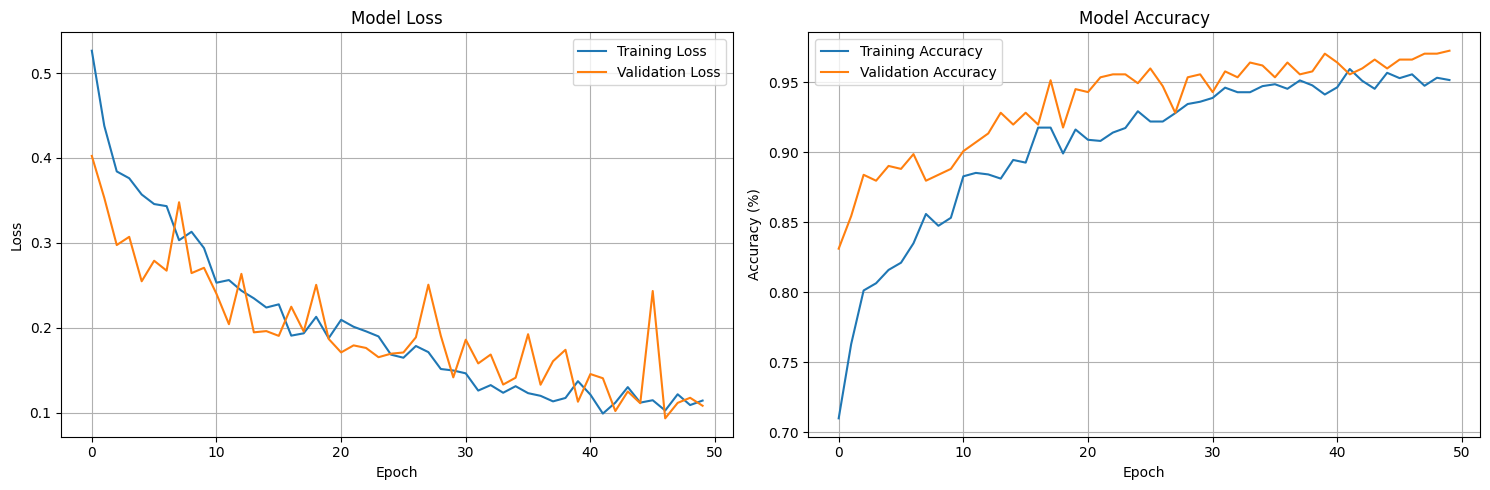

In [ ]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history['train_loss'], history['val_loss'], history['train_acc'], history['val_acc'])

In [ ]:
# Load best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EfficientNetLSTM(hidden_size=256, num_layers=2, dropout=0.5).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
print("✓ Model loaded successfully!")

✓ Model loaded successfully!


In [ ]:
def predict_video(model, video_path, transform, device, num_frames=16, threshold=0.5):
    """
    Dự đoán video có Fall hay không

    Args:
        model: Model đã train
        video_path: Đường dẫn đến video
        transform: Transform để preprocess
        device: cuda/cpu
        num_frames: Số frame để extract
        threshold: Ngưỡng phân loại

    Returns:
        prediction: 'Fall' hoặc 'No_Fall'
        confidence: Độ tin cậy (0-1)
    """
    # Extract frames
    frames = extract_frame(video_path, num_frames)

    # Transform
    augmented_frames = transform(images=frames)['images']

    # Add batch dimension
    video_tensor = augmented_frames.unsqueeze(0).to(device)  # (1, num_frames, C, H, W)

    # Predict
    with torch.no_grad():
        output = model(video_tensor)
        probability = torch.sigmoid(output).item()

    # Classify
    prediction = 'Fall' if probability > threshold else 'No_Fall'
    confidence = probability if probability > 0.5 else (1 - probability)

    return prediction, confidence, probability

In [ ]:
# Test với 1 video
test_video_path = '/kaggle/input/dataset-fall/split_dataset/test/Fall/Raw_Video/20240912_101943.mp4'

prediction, confidence, prob = predict_video(
    model=model,
    video_path=test_video_path,
    transform=val_test_transform,
    device=device,
    num_frames=NUM_FRAMES
)

print(f"Video: {test_video_path}")
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.2%}")
print(f"Fall Probability: {prob:.4f}")

Video: /kaggle/input/dataset-fall/split_dataset/test/Fall/Raw_Video/20240912_101943.mp4
Prediction: Fall
Confidence: 99.99%
Fall Probability: 0.9999


In [ ]:
# Test với 1 video
test_video_path = '/kaggle/input/dataset-fall/split_dataset/test/No_Fall/Raw_Video/B_D_0004.mp4'

prediction, confidence, prob = predict_video(
    model=model,
    video_path=test_video_path,
    transform=val_test_transform,
    device=device,
    num_frames=NUM_FRAMES
)

print(f"Video: {test_video_path}")
print(f"Prediction: {prediction}")
print(f"Confidence: {confidence:.2%}")
print(f"Fall Probability: {prob:.4f}")

Video: /kaggle/input/dataset-fall/split_dataset/test/No_Fall/Raw_Video/B_D_0004.mp4
Prediction: No_Fall
Confidence: 99.95%
Fall Probability: 0.0005


Testing: 100%|██████████| 57/57 [00:10<00:00,  5.23it/s]


TEST SET EVALUATION
Accuracy:  0.9644
Precision: 0.9756
Recall:    0.9479
F1-Score:  0.9615

Confusion Matrix:
[[233   5]
 [ 11 200]]


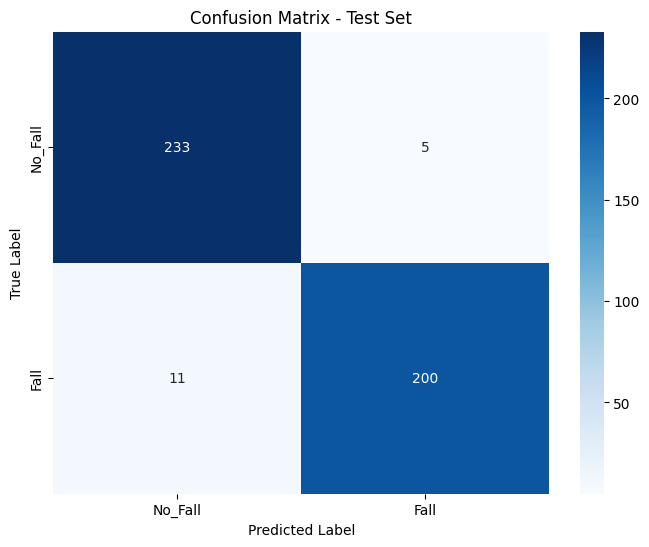

In [ ]:
def evaluate_test_set(model, test_loader, device):
    """Đánh giá trên test set"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for videos, labels in tqdm(test_loader, desc="Testing"):
            videos = videos.to(device)
            labels = labels.float().to(device)

            outputs = model(videos)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).float()

            # FIX: Đảm bảo là 1D tensor trước khi extend
            if predicted.dim() == 0:
                # Nếu là scalar (batch_size=1), wrap thành list
                all_preds.append(predicted.item())
                all_labels.append(labels.item())
                all_probs.append(probs.item())
            else:
                # Nếu là tensor 1D, convert sang list
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())
                all_probs.extend(probs.cpu().numpy().tolist())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("=" * 50)
    print("TEST SET EVALUATION")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No_Fall', 'Fall'],
                yticklabels=['No_Fall', 'Fall'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix - Test Set')
    plt.show()

    return accuracy, precision, recall, f1, cm

# Chạy evaluation
test_acc, test_prec, test_rec, test_f1, test_cm = evaluate_test_set(model, test_batch, device)